# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

# Package to filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data Loading and other standard packages
import sqlite3
import nltk
import string
import re
import pickle
import os
import time
import string
import pickle
import pandas as pd
import numpy as np
from scipy import interp
from tqdm import tqdm
from scipy.sparse import find
from wordcloud import WordCloud, STOPWORDS


# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing packages
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# Packages related to text processing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn import decomposition
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Packages for performance metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Packages for crossvalidation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

# Model packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


C:\Users\soura\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

## Time based splitting
* Sort the data based on `Time` column
* Get the 80% data for train and 20% data on test

In [22]:
# time based splitting for a dataframe
def split_time_based(df, time_col, train_perc):
    if type(df).__name__ != 'DataFrame':
        print("Please provide a dataframe!")
    if type(time_col).__name__ != 'list':
        print("Please porvide the time column as list")
    # Sort the dataframe based on time column
    df.sort_values(by=time_col, inplace=True)
    df_row, df_col = df.shape
    train_row = round(df_row * (train_perc/100))
    test_row = df_row - train_row
    return df.head(train_row), df.tail(test_row)

In [23]:
# Splitting the data based on Time column, where train=80% and test=20%
final_train, final_test = split_time_based(final, ['Time'], 80)
print(final_train.shape)
print(final_test.shape)

(70218, 10)
(17555, 10)


In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_train = []
# tqdm is for printing the status bar
for sentance in tqdm(final_train['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_train.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 70218/70218 [00:19<00:00, 3593.94it/s]


In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_test = []
# tqdm is for printing the status bar
for sentance in tqdm(final_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [00:04<00:00, 3519.68it/s]


In [26]:
print("Train: ",len(preprocessed_reviews_train))
print("Test: ",len(preprocessed_reviews_test))

Train:  70218
Test:  17555


In [27]:
y_train = final_train['Score']
y_test = final_test['Score']

y_train = y_train.values
y_test = y_test.values

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW for Train data
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews_train)
bow_features = count_vect.get_feature_names()
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70218, 49074)
the number of unique words  49074


In [29]:
#BoW for Test data
final_counts_test = count_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 49074)
the number of unique words  49074


## [4.2] TF-IDF

In [30]:
#TFIDF on Train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews_train)
tfidf_features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70218, 41851)
the number of unique words including both unigrams and bigrams  41851


In [31]:
# TFIDF on Test data
final_tf_idf_test = tf_idf_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (17555, 41851)
the number of unique words including both unigrams and bigrams  41851


## [4.3] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
list_of_sentance_test=[]
for sentance in preprocessed_reviews_train:
    list_of_sentance_train.append(sentance.split())
for sentance in preprocessed_reviews_test:
    list_of_sentance_test.append(sentance.split())

# Applying to W2V model on train data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=500, workers=4) # min count --> ignore those words having count less than 5, size --> dimensions for each word

In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15761
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [34]:
# average Word2Vec on Train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [01:37<00:00, 722.78it/s]


70218
500


In [35]:
# average Word2Vec on Test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:24<00:00, 715.22it/s]


17555
500


#### [4.3.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec for Train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 70218/70218 [16:39<00:00, 70.29it/s]


In [38]:
# TF-IDF weighted Word2Vec for Test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [04:11<00:00, 69.74it/s]


### Pickling the data
* Pickling the train and test data for all the implementations
* BoW
* TFIDF
* Avg-W2Vec
* TFIDF W2Vec

In [39]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'
bow_features_f = 'bow_features.pkl'
tfidf_features_f = 'tfidf_features.pkl'
w2v_words_f = 'w2v_words.pkl'

obj1 = open(bow_features_f,'wb')
pickle.dump(bow_features, obj1)
obj1.close()
obj1 = open(tfidf_features_f,'wb')
pickle.dump(tfidf_features, obj1)
obj1.close()
obj1 = open(w2v_words_f,'wb')
pickle.dump(w2v_words, obj1)
obj1.close()

obj1 = open(bow_train,'wb')
pickle.dump(final_counts_train, obj1)
obj1.close()

obj2 = open(bow_test,'wb')
pickle.dump(final_counts_test, obj2)
obj2.close()

obj3 = open(tfidf_train,'wb')
pickle.dump(final_tf_idf_train, obj3)
obj3.close()

obj4 = open(tfidf_test,'wb')
pickle.dump(final_tf_idf_test, obj4)
obj4.close()

obj5 = open(avgw2v_train,'wb')
pickle.dump(sent_vectors_train, obj5)
obj5.close()

obj6 = open(avgw2v_test,'wb')
pickle.dump(sent_vectors_test, obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'wb')
pickle.dump(tfidf_sent_vectors_train, obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'wb')
pickle.dump(tfidf_sent_vectors_test, obj8)
obj8.close()

In [40]:
# Pickle class data
import pickle
y_train_file = 'y_train.pkl'
y_test_file = 'y_test.pkl'

obj9 = open(y_train_file,'wb')
pickle.dump(y_train, obj9)
obj9.close()

obj10 = open(y_test_file,'wb')
pickle.dump(y_test, obj10)
obj10.close()

### Unpickle the files before processing

In [2]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'
bow_features_f = 'bow_features.pkl'
tfidf_features_f = 'tfidf_features.pkl'
w2v_words_f = 'w2v_words.pkl'

obj1 = open(bow_features_f,'rb')
bow_features = pickle.load(obj1)
obj1.close()
obj1 = open(tfidf_features_f,'rb')
tfidf_features = pickle.load(obj1)
obj1.close()
obj1 = open(w2v_words_f,'rb')
w2v_words = pickle.load(obj1)
obj1.close()

obj1 = open(bow_train,'rb')
final_counts_train = pickle.load(obj1)
obj1.close()

obj2 = open(bow_test,'rb')
final_counts_test = pickle.load(obj2)
obj2.close()

obj3 = open(tfidf_train,'rb')
final_tf_idf_train = pickle.load(obj3)
obj3.close()

obj4 = open(tfidf_test,'rb')
final_tf_idf_test = pickle.load(obj4)
obj4.close()

obj5 = open(avgw2v_train,'rb')
sent_vectors_train = pickle.load(obj5)
obj5.close()

obj6 = open(avgw2v_test,'rb')
sent_vectors_test = pickle.load(obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'rb')
tfidf_sent_vectors_train = pickle.load(obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'rb')
tfidf_sent_vectors_test = pickle.load(obj8)
obj8.close()

In [3]:
# Unpickle class data
import pickle
y_train_file = 'y_train.pkl'
y_test_file = 'y_test.pkl'

obj9 = open(y_train_file,'rb')
y_train = pickle.load(obj9)
obj9.close()

obj10 = open(y_test_file,'rb')
y_test = pickle.load(obj10)
obj10.close()

# Applying Logistic Regression

In [4]:
#defining function to apply Logistic Regression
def apply_logistic_regression(x_train, y_train, C_values, cross_val_number, regularization_param):
    C_vals = C_values
    tscv = TimeSeriesSplit(n_splits=cross_val_number)
    
    # define Logistic Regression to use in crossvalidation
    parameter = {'C':C_vals, 'penalty':regularization_param}
    lr = LogisticRegression()
    clf = GridSearchCV(lr, parameter, cv=tscv, scoring='roc_auc', n_jobs=1, verbose=1) #Use GridSearchCV for 10 fold cross validation
    clf.fit(x_train, y_train)
    return clf

In [5]:
#defining function to apply Logistic Regression with normal cross validation
def apply_logistic_regression_kfold(x_train, y_train, C_values, cross_val_number, regularization_param):
    kf = KFold(n_splits=cross_val_number)
    kf.get_n_splits(x_train)
    local_auc_score_train = []
    global_auc_score_train = []
    local_auc_score_test = []
    global_auc_score_test = []

    
    for c_v in tqdm(C_values):
        for train_index, test_index in kf.split(x_train):
            lr = LogisticRegression(penalty=regularization_param[0],C=c_v)
            lr.fit(x_train[train_index], y_train[train_index])
            pred_log_proba = lr.predict_log_proba(x_train[train_index])
            pred_log_proba1 = lr.predict_log_proba(x_train[test_index])
            fpr, tpr, _ = roc_curve(y_train[train_index], pred_log_proba[:,1])
            fpr1, tpr1, _ = roc_curve(y_train[test_index], pred_log_proba1[:,1])
            auc_score = auc(fpr, tpr)
            auc_score1 = auc(fpr1, tpr1)
            local_auc_score_train.append(auc_score)
            local_auc_score_test.append(auc_score1)
        global_auc_score_train.append(sum(local_auc_score_train)/len(local_auc_score_train))
        global_auc_score_test.append(sum(local_auc_score_test)/len(local_auc_score_test))
    return global_auc_score_train,global_auc_score_test

In [6]:
# Define Function to plot AUC vs alpha curve
def plot_auc_C_curve(xaxis1, yaxis1, xaxis2, yaxis2, title, xlab, ylab):
    plt.title(title)
    plt.plot(xaxis1, yaxis1)
    plt.plot(xaxis2, yaxis2)
    plt.legend(('Train', 'Test'))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [7]:
# Define function to Plot the ROC curve
def plot_roc_curve_for_test(fpr, tpr, title):
    plt.title(title)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
    plt.plot(fpr, tpr, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [8]:
# Define function to percentile change
def plot_percentile_change(perc_val, perc_array):
    plt.title('Percentile change in weight vectors')
    plt.plot(perc_array, perc_val, color='b')
    plt.xlabel('nth percentile')
    plt.ylabel('nth percentile value')
    plt.show()

In [9]:
# Define function to standardize data
def perform_standardization(x_train, x_test):
    if (type(x_train).__name__ == 'csr_matrix') and (type(x_test).__name__ == 'csr_matrix'):
        scaler = MaxAbsScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std
    else:
        scaler = StandardScaler().fit(x_train)
        x_train_std = scaler.transform(x_train)
        x_test_std = scaler.transform(x_test)
        return x_train_std, x_test_std

In [10]:
def percentile_change_values(weights_diff, low_perc, high_perc):
    percentile_array = np.linspace(low_perc, high_perc, (high_perc-low_perc)/0.1)
    change_percentile = []
    for perc in percentile_array:
        change_percentile.append(np.percentile(weights_diff, perc))
    return change_percentile,percentile_array

In [11]:
def perturbation_test(clf,X_data,Y_data,best_C, best_penalty):
    epsilon = 10**-6
    small_noise = np.random.uniform(low=-0.0001, high=0.0001)
    percentiles = [0,10,20,30,40,50,60,70,90,100]
    percentile_values = []
    weights_before = clf.coef_[0]
    weights_before += epsilon #To avoid 'DivisionByZero error'
    if (type(X_data).__name__ == 'csr_matrix'):
        X_data.data += small_noise
        clf_after = LogisticRegression(penalty=best_penalty,C=best_C)
        clf_after.fit(X_data, Y_data)
    else:
        pass
    weights_after = clf_after.coef_[0]
    weights_after += epsilon
    weights_diff = (abs(weights_after - weights_before)/weights_before) * 100
    for perc in percentiles:
        percentile_values.append(np.percentile(weights_diff, perc))
    return weights_diff,percentile_values

In [12]:
# Define function for word cloud
def create_word_cloud(data,font_sz, fig_size):
    plt.figure(figsize=fig_size)

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
            background_color='white',
            stopwords=stopwords,
            max_words=200,
            max_font_size=font_sz, 
            scale=3,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(data))
    plt.imshow(wordcloud)
    plt.show()

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [13]:
C_values = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]

In [57]:
# Standardize the data
final_counts_train_std, final_counts_test_std = perform_standardization(final_counts_train, final_counts_test)

# Deleting objects to free memory
del final_counts_train
del final_counts_test

In [12]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
cross_val_number = 10
regularization_param = ['l1']
clf = apply_logistic_regression(final_counts_train_std, y_train, C_values, cross_val_number, regularization_param)

Wall time: 0 ns
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 80.9min finished


In [15]:
# keeping the object in file for further use
bow_model = 'bow_lr.pkl'
obj1 = open(bow_model,'wb')
pickle.dump(clf, obj1)
obj1.close()

In [16]:
# Getting the object return
bow_model = 'bow_lr.pkl'

obj9 = open(bow_model,'rb')
clf_bow = pickle.load(obj9)
obj9.close()

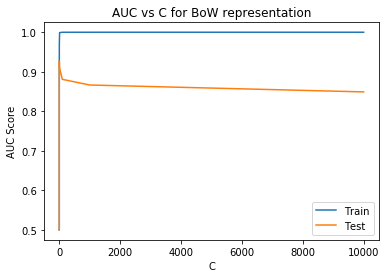

In [19]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, clf_bow.cv_results_['mean_train_score'], C_values, clf_bow.cv_results_['mean_test_score'],
                    'AUC vs C for BoW representation', 'C', 'AUC Score')

In [21]:
print("Best HyperParameter: ",clf_bow.best_params_)
print("Best Score: %.2f%%"%(clf_bow.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Score: 92.69%


Accuracy on test set: 91.740%
Precision on test set: 0.933
Recall on test set: 0.971
F1-Score on test set: 0.951



Confusion Matrix of test set


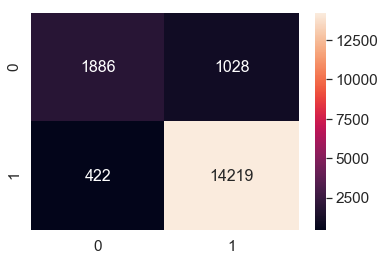

In [26]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty=clf_bow.best_params_['penalty'],C=clf_bow.best_params_['C'])
lr_optimal.fit(final_counts_train_std, y_train)
log_proba = lr_optimal.predict_log_proba(final_counts_test_std)
pred = lr_optimal.predict(final_counts_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

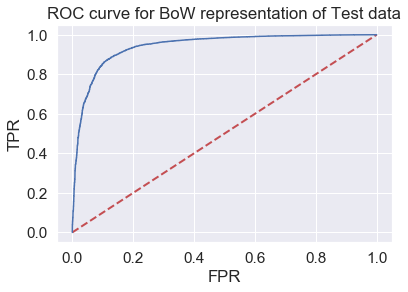

In [27]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for BoW representation of Test data')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [33]:
print("The sparsity of the weight vector is: {}%".format(round((np.count_nonzero(lr_optimal.coef_)/lr_optimal.coef_.shape[1])*100,2)))

The sparsity of the weight vector is: 6.73%


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [37]:
%time
# Apply Logistic Regression on Standardized data for L2 Regularization
cross_val_number = 10
regularization_param = ['l2']
clf = apply_logistic_regression(final_counts_train_std, y_train, C_values, cross_val_number, regularization_param)

Wall time: 0 ns
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.5min finished


In [38]:
# keeping the object in file for further use
bow_model_l2 = 'bow_lr_l2.pkl'
obj1 = open(bow_model_l2,'wb')
pickle.dump(clf, obj1)
obj1.close()

In [53]:
# Getting the object return
bow_model_l2 = 'bow_lr_l2.pkl'
obj9 = open(bow_model_l2,'rb')
clf_bow_l2 = pickle.load(obj9)
obj9.close()

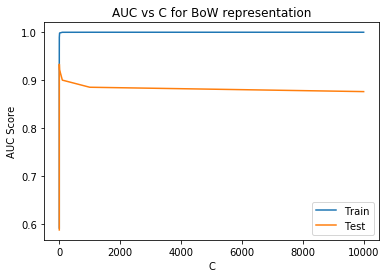

In [54]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, clf_bow_l2.cv_results_['mean_train_score'], C_values, clf_bow_l2.cv_results_['mean_test_score'],
                    'AUC vs C for BoW representation', 'C', 'AUC Score')

In [55]:
print("Best HyperParameter: ",clf_bow_l2.best_params_)
print("Best Score: %.2f%%"%(clf_bow_l2.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Score: 93.32%


Accuracy on test set: 91.490%
Precision on test set: 0.927
Recall on test set: 0.975
F1-Score on test set: 0.950



Confusion Matrix of test set


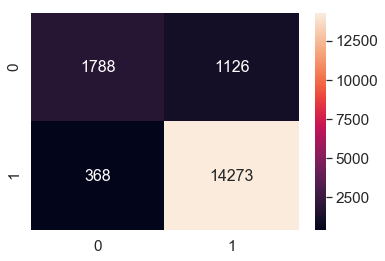

In [58]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty=clf_bow_l2.best_params_['penalty'],C=clf_bow_l2.best_params_['C'])
lr_optimal.fit(final_counts_train_std, y_train)
log_proba = lr_optimal.predict_log_proba(final_counts_test_std)
pred = lr_optimal.predict(final_counts_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

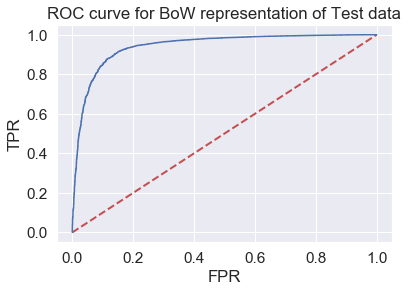

In [59]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for BoW representation of Test data')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [60]:
# Getting the weights and there primary percentile values
weights_diff,percentile_values=perturbation_test(lr_optimal,final_counts_train_std, y_train, 1, 'l2')

In [61]:
percentile_values

[-331.2924728998152,
 -0.013428509744036378,
 -0.004440892139104243,
 0.0004847559704402971,
 0.0032545264948097676,
 0.00634066130071681,
 0.010213949348055756,
 0.015407147726798229,
 0.039545700235569,
 25.301811412452924]

In [62]:
# We can see that percentile values changes between 99 and 100th percentile
precided_percentile,percentile_array = percentile_change_values(weights_diff, 99, 100)

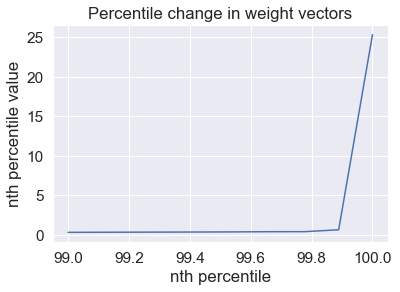

In [63]:
plot_percentile_change(precided_percentile,percentile_array)

In [64]:
precided_percentile

[0.32989728075462815,
 0.33929380373045454,
 0.3531861771310126,
 0.36113641920216,
 0.37246373543950806,
 0.3868642571957779,
 0.41336361855785486,
 0.4154068387094745,
 0.6542540291887147,
 25.301811412452924]

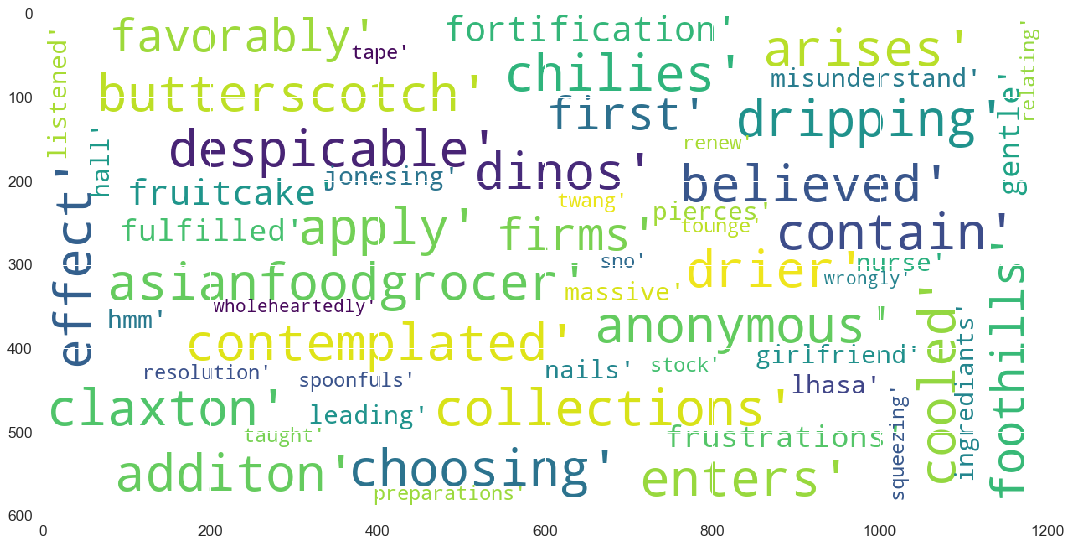

In [106]:
# We can observe that the thresold is 0.65
# The features are
create_word_cloud(np.array(bow_features)[np.where(weights_diff > 0.65)[0]], 20, (18,13))

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

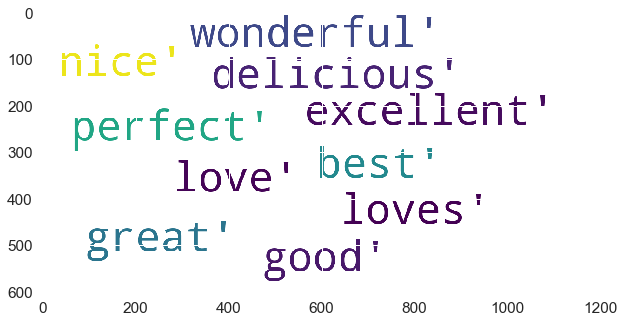

In [109]:
create_word_cloud(np.array(bow_features)[lr_optimal.coef_[0].argsort()[::-1][:10]],30,(10,6))

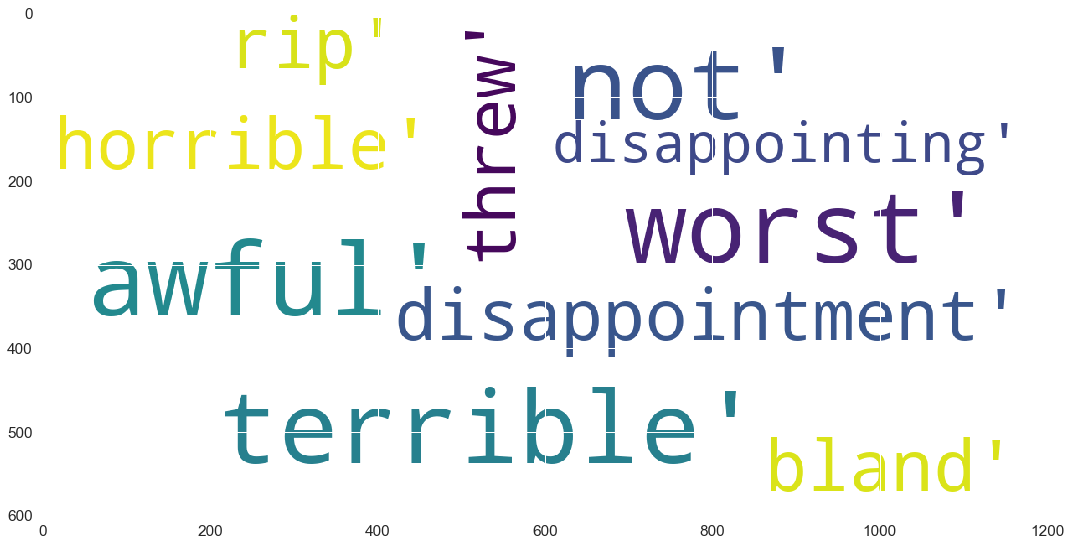

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [91]:
lr_optimal.coef_[0]

array([-0.08922162,  0.54918648,  0.09307656, ..., -0.20120478,
        0.00254405,  0.09819262])

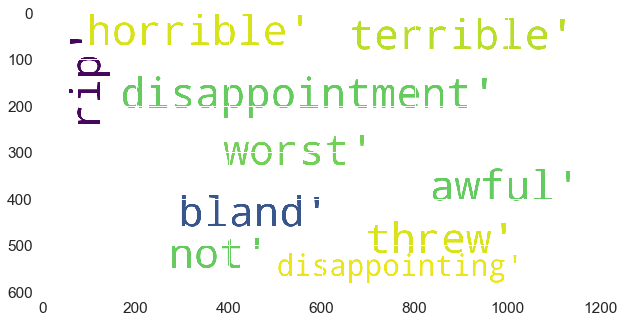

In [110]:
create_word_cloud(np.array(bow_features)[lr_optimal.coef_[0].argsort()[:10]], 30, (10,6))

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [100]:
# Standardize the data
final_tf_idf_train_std, final_tf_idf_test_std = perform_standardization(final_tf_idf_train, final_tf_idf_test)

# Deleting objects to free memory
del final_tf_idf_train
del final_tf_idf_test

In [41]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
cross_val_number = 10
regularization_param = ['l1']
clf = apply_logistic_regression(final_tf_idf_train_std, y_train, C_values, cross_val_number, regularization_param)

Wall time: 0 ns
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   52.8s finished


In [42]:
# keeping the object in file for further use
tfidf_model_l1 = 'tfidf_model_l1.pkl'
obj1 = open(tfidf_model_l1,'wb')
pickle.dump(clf, obj1)
obj1.close()

In [111]:
# Getting the object return
tfidf_model_l1 = 'tfidf_model_l1.pkl'

obj9 = open(tfidf_model_l1,'rb')
clf_tfidf_l1 = pickle.load(obj9)
obj9.close()

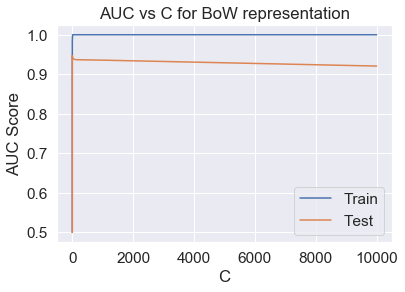

In [113]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, clf_tfidf_l1.cv_results_['mean_train_score'], C_values, clf_tfidf_l1.cv_results_['mean_test_score'],
                    'AUC vs C for BoW representation', 'C', 'AUC Score')

In [114]:
print("Best HyperParameter: ",clf_tfidf_l1.best_params_)
print("Best Score: %.2f%%"%(clf_tfidf_l1.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Score: 94.73%


Accuracy on test set: 93.255%
Precision on test set: 0.946
Recall on test set: 0.975
F1-Score on test set: 0.960



Confusion Matrix of test set


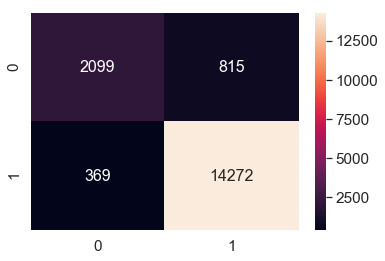

In [115]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty=clf_tfidf_l1.best_params_['penalty'],C=clf_tfidf_l1.best_params_['C'])
lr_optimal.fit(final_tf_idf_train_std, y_train)
log_proba = lr_optimal.predict_log_proba(final_tf_idf_test_std)
pred = lr_optimal.predict(final_tf_idf_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

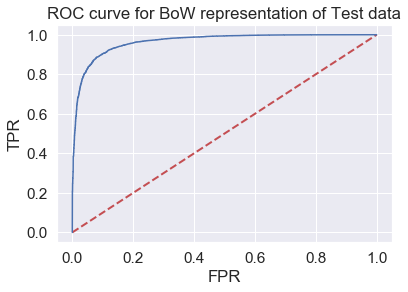

In [116]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for TFIDF representation of Test data')

#### [5.2.1.1] Calculating sparsity on weight vector obtained using L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [117]:
print("The sparsity of the weight vector is: {}%".format(round((np.count_nonzero(lr_optimal.coef_)/lr_optimal.coef_.shape[1])*100,2)))

The sparsity of the weight vector is: 10.62%


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [45]:
%time
# Apply Logistic Regression on Standardized data for L2 Regularization
cross_val_number = 10
regularization_param = ['l2']
clf = apply_logistic_regression(final_tf_idf_train_std, y_train, C_values, cross_val_number, regularization_param)

Wall time: 0 ns
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.3min finished


In [46]:
# keeping the object in file for further use
tfidf_model_l2 = 'tfidf_model_l2.pkl'
obj1 = open(tfidf_model_l2,'wb')
pickle.dump(clf, obj1)
obj1.close()

In [118]:
# Getting the object return
tfidf_model_l2 = 'tfidf_model_l2.pkl'

obj9 = open(tfidf_model_l2,'rb')
clf_tfidf_l2 = pickle.load(obj9)
obj9.close()

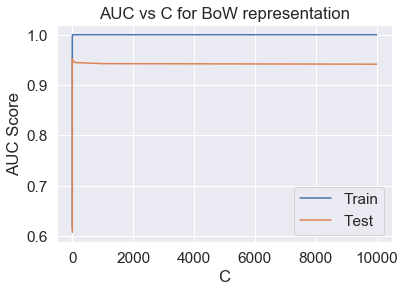

In [119]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, clf_tfidf_l2.cv_results_['mean_train_score'], C_values, clf_tfidf_l2.cv_results_['mean_test_score'],
                    'AUC vs C for BoW representation', 'C', 'AUC Score')

In [120]:
print("Best HyperParameter: ",clf_tfidf_l2.best_params_)
print("Best Score: %.2f%%"%(clf_tfidf_l2.best_score_*100))

Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Score: 95.24%


Accuracy on test set: 93.512%
Precision on test set: 0.945
Recall on test set: 0.979
F1-Score on test set: 0.962



Confusion Matrix of test set


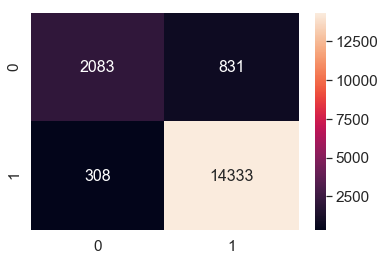

In [121]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty=clf_tfidf_l2.best_params_['penalty'],C=clf_tfidf_l2.best_params_['C'])
lr_optimal.fit(final_tf_idf_train_std, y_train)
log_proba = lr_optimal.predict_log_proba(final_tf_idf_test_std)
pred = lr_optimal.predict(final_tf_idf_test_std)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

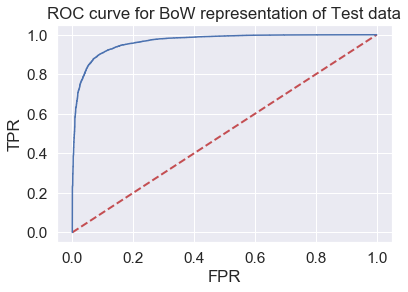

In [122]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for TFIDF representation of Test data')

#### [5.2.2.1] Performing pertubation test (multicollinearity check) on TFIDF,<font color='red'> SET 2</font>

In [123]:
# Getting the weights and there primary percentile values
weights_diff,percentile_values=perturbation_test(lr_optimal,final_tf_idf_train_std, y_train, 1, 'l2')

In [124]:
percentile_values

[-53.18431584966788,
 -0.021615092858515896,
 -0.009040614337155297,
 -0.004053859664782765,
 -0.0004997365734027831,
 0.0019068170645980004,
 0.00439857841235791,
 0.007760476144537477,
 0.024827610328223233,
 238.91656763045668]

In [125]:
# We can see that percentile values changes between 99 and 100th percentile
precided_percentile,percentile_array = percentile_change_values(weights_diff, 99, 100)

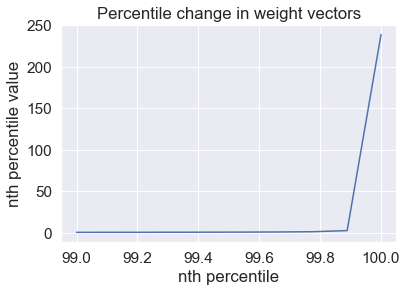

In [126]:
plot_percentile_change(precided_percentile,percentile_array)

In [127]:
precided_percentile

[0.21358749356119922,
 0.2464977274949537,
 0.28449485154512943,
 0.33625186573431104,
 0.4029613414277866,
 0.5039802956064373,
 0.6425079162382117,
 0.9759878482549513,
 2.3150059056259593,
 238.91656763045668]

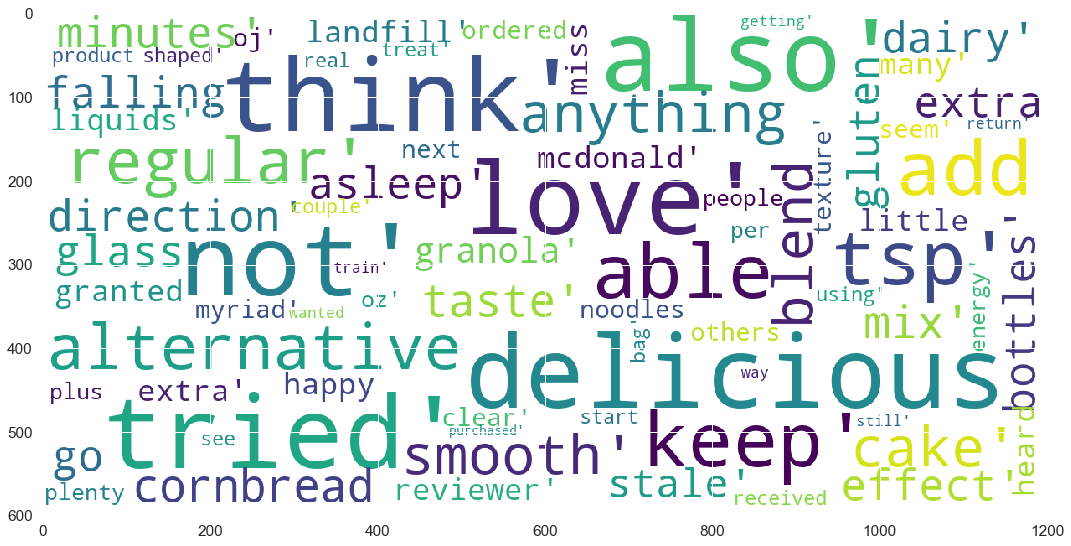

In [135]:
# We can observe that the thresold is 2.31
# The features are
create_word_cloud(np.array(tfidf_features)[np.where(weights_diff > 2.31)[0]], 40, (18,13))

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

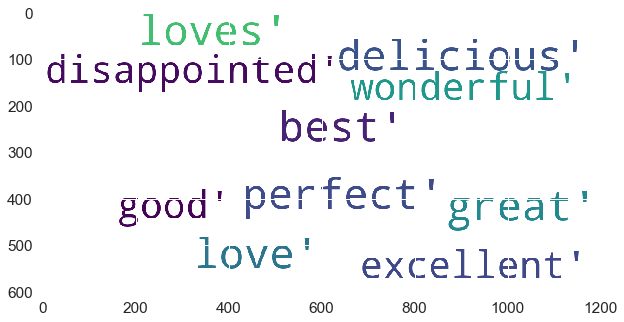

In [133]:
create_word_cloud(np.array(tfidf_features)[lr_optimal.coef_[0].argsort()[::-1][:10]], 30, (10,6))

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

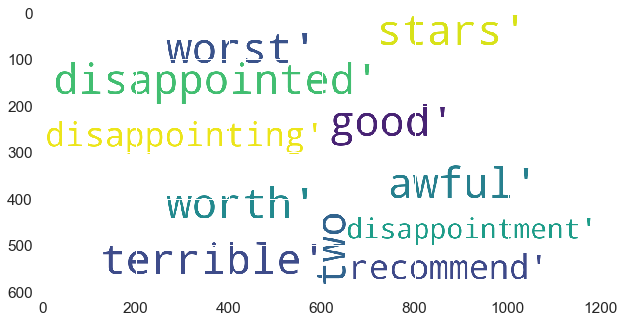

In [134]:
create_word_cloud(np.array(tfidf_features)[lr_optimal.coef_[0].argsort()[:10]], 30, (10,6))

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [14]:
# Standardize the data
sent_vectors_train_std, sent_vectors_test_std = perform_standardization(sent_vectors_train, sent_vectors_test)

# Deleting objects to free memory
del sent_vectors_train
del sent_vectors_test

In [ ]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
sent_vectors_train_trim = sent_vectors_train_std[:50000]
sent_vectors_test_trim = sent_vectors_test_std[:7500]
y_train_trim = y_train[:50000]
y_test_trim = y_test[:7500]
cross_val_number = 2
regularization_param = ['l1']
auc_scores_train,auc_scores_test = apply_logistic_regression_kfold(sent_vectors_train_trim, y_train_trim, C_values, cross_val_number, regularization_param)

Wall time: 0 ns


 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:38<04:14, 63.71s/it]

In [150]:
# keeping the object in file for further use
avgw2v_model_l1_train = 'avgw2v_model_l1_train.pkl'
obj1 = open(avgw2v_model_l1_train,'wb')
pickle.dump(auc_scores_train, obj1)
obj1.close()
avgw2v_model_l1_test = 'avgw2v_model_l1_test.pkl'
obj1 = open(avgw2v_model_l1_test,'wb')
pickle.dump(auc_scores_test, obj1)
obj1.close()

In [151]:
# Getting the object return
avgw2v_model_l1_train = 'avgw2v_model_l1_train.pkl'
avgw2v_model_l1_test = 'avgw2v_model_l1_test.pkl'
obj9 = open(avgw2v_model_l1_train,'rb')
auc_scores_train_avgw2v_l1 = pickle.load(obj9)
obj9.close()
obj9 = open(avgw2v_model_l1_test,'rb')
auc_scores_test_avgw2v_l1 = pickle.load(obj9)
obj9.close()

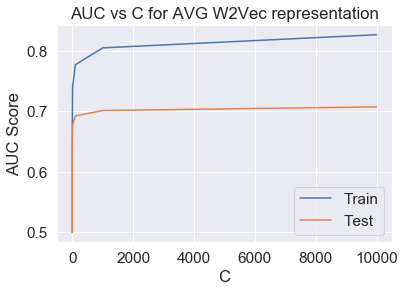

In [152]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, auc_scores_train_avgw2v_l1, C_values, auc_scores_test_avgw2v_l1,
                    'AUC vs C for AVG W2Vec representation', 'C', 'AUC Score')

In [158]:
print("Best HyperParameter: ",C_values[auc_scores_test_avgw2v_l1.index(max(auc_scores_test_avgw2v_l1))])
print("Best Score: %.2f%%"%(max(auc_scores_test_avgw2v_l1)))

Best HyperParameter:  10000
Best Score: 0.71%


Accuracy on test set: 82.000%
Precision on test set: 0.882
Recall on test set: 0.903
F1-Score on test set: 0.892



Confusion Matrix of test set


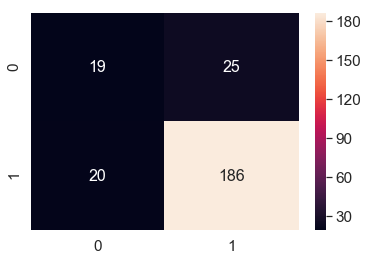

In [160]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty='l1',C=1000)
lr_optimal.fit(sent_vectors_train_trim, y_train_trim)
log_proba = lr_optimal.predict_log_proba(sent_vectors_test_trim)
pred = lr_optimal.predict(sent_vectors_test_trim)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test_trim, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test_trim, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test_trim, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test_trim, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test_trim, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

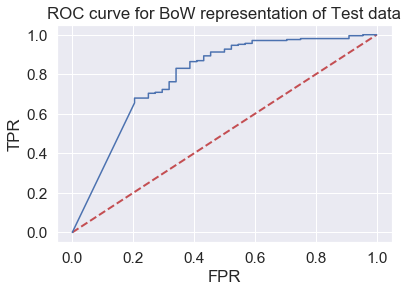

In [179]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_trim, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for AVG W2Vec representation of Test data')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [17]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
sent_vectors_train_trim = sent_vectors_train_std[:1000]
sent_vectors_test_trim = sent_vectors_test_std[:250]
y_train_trim = y_train[:1000]
y_test_trim = y_test[:250]
cross_val_number = 3
regularization_param = ['l2']
auc_scores_train,auc_scores_test = apply_logistic_regression_kfold(sent_vectors_train_trim, y_train_trim, C_values, cross_val_number, regularization_param)

Wall time: 0 ns


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.29it/s]


In [162]:
# keeping the object in file for further use
avgw2v_model_l2_train = 'avgw2v_model_l2_train.pkl'
obj1 = open(avgw2v_model_l2_train,'wb')
pickle.dump(auc_scores_train, obj1)
obj1.close()
avgw2v_model_l2_test = 'avgw2v_model_l2_test.pkl'
obj1 = open(avgw2v_model_l2_test,'wb')
pickle.dump(auc_scores_test, obj1)
obj1.close()

In [163]:
# Getting the object return
avgw2v_model_l2_train = 'avgw2v_model_l2_train.pkl'
avgw2v_model_l2_test = 'avgw2v_model_l2_test.pkl'
obj9 = open(avgw2v_model_l2_train,'rb')
auc_scores_train_avgw2v_l2 = pickle.load(obj9)
obj9.close()
obj9 = open(avgw2v_model_l2_test,'rb')
auc_scores_test_avgw2v_l2 = pickle.load(obj9)
obj9.close()

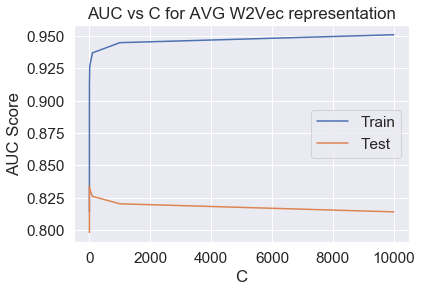

In [164]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, auc_scores_train_avgw2v_l2, C_values, auc_scores_test_avgw2v_l2,
                    'AUC vs C for AVG W2Vec representation', 'C', 'AUC Score')

In [165]:
print("Best HyperParameter: ",C_values[auc_scores_test_avgw2v_l2.index(max(auc_scores_test_avgw2v_l2))])
print("Best Score: %.2f%%"%(max(auc_scores_test_avgw2v_l2)))

Best HyperParameter:  1
Best Score: 0.83%


Accuracy on test set: 85.200%
Precision on test set: 0.889
Recall on test set: 0.937
F1-Score on test set: 0.913



Confusion Matrix of test set


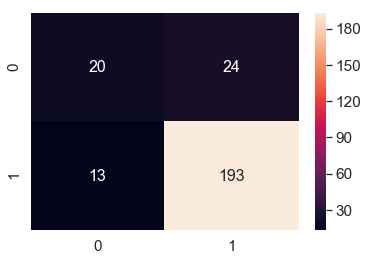

In [166]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty='l2',C=1)
lr_optimal.fit(sent_vectors_train_trim, y_train_trim)
log_proba = lr_optimal.predict_log_proba(sent_vectors_test_trim)
pred = lr_optimal.predict(sent_vectors_test_trim)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test_trim, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test_trim, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test_trim, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test_trim, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test_trim, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

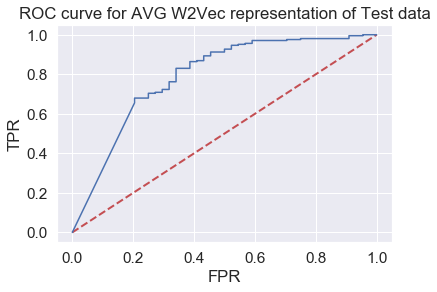

In [180]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_trim, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for AVG W2Vec representation of Test data')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [138]:
# Standardize the data
tfidf_sent_vectors_train_std, tfidf_sent_vectors_test_std = perform_standardization(tfidf_sent_vectors_train, tfidf_sent_vectors_test)

# Deleting objects to free memory
del tfidf_sent_vectors_train
del tfidf_sent_vectors_test

In [167]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
tfidf_sent_vectors_train_trim = tfidf_sent_vectors_train_std[:1000]
tfidf_sent_vectors_test_trim = tfidf_sent_vectors_test_std[:250]
y_train_trim = y_train[:1000]
y_test_trim = y_test[:250]
cross_val_number = 10
regularization_param = ['l1']
auc_scores_train,auc_scores_test = apply_logistic_regression_kfold(tfidf_sent_vectors_train_trim, y_train_trim, C_values, cross_val_number, regularization_param)

Wall time: 0 ns


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:50<00:00, 58.28s/it]


In [168]:
# keeping the object in file for further use
tfidf_avgw2v_model_l1_train = 'tfidf_avgw2v_model_l1_train.pkl'
obj1 = open(tfidf_avgw2v_model_l1_train,'wb')
pickle.dump(auc_scores_train, obj1)
obj1.close()
tfidf_avgw2v_model_l1_test = 'tfidf_avgw2v_model_l1_test.pkl'
obj1 = open(tfidf_avgw2v_model_l1_test,'wb')
pickle.dump(auc_scores_test, obj1)
obj1.close()

In [169]:
# Getting the object return
tfidf_avgw2v_model_l1_train = 'tfidf_avgw2v_model_l1_train.pkl'
tfidf_avgw2v_model_l1_test = 'tfidf_avgw2v_model_l1_test.pkl'
obj9 = open(tfidf_avgw2v_model_l1_train,'rb')
auc_scores_train_tftdf_avgw2v_l1 = pickle.load(obj9)
obj9.close()
obj9 = open(tfidf_avgw2v_model_l1_test,'rb')
auc_scores_test_tftdf_avgw2v_l1 = pickle.load(obj9)
obj9.close()

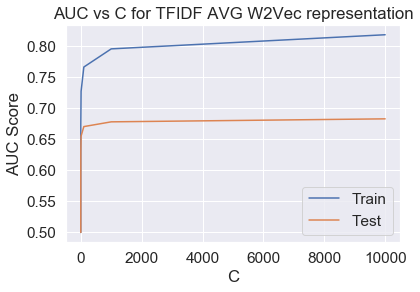

In [170]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, auc_scores_train_tftdf_avgw2v_l1, C_values, auc_scores_test_tftdf_avgw2v_l1,
                    'AUC vs C for TFIDF AVG W2Vec representation', 'C', 'AUC Score')

In [171]:
print("Best HyperParameter: ",C_values[auc_scores_test_tftdf_avgw2v_l1.index(max(auc_scores_test_tftdf_avgw2v_l1))])
print("Best Score: %.2f%%"%(max(auc_scores_test_tftdf_avgw2v_l1)))

Best HyperParameter:  10000
Best Score: 0.68%


Accuracy on test set: 85.600%
Precision on test set: 0.897
Recall on test set: 0.932
F1-Score on test set: 0.914



Confusion Matrix of test set


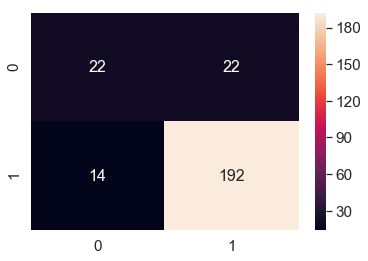

In [172]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty='l1',C=1000)
lr_optimal.fit(tfidf_sent_vectors_train_trim, y_train_trim)
log_proba = lr_optimal.predict_log_proba(tfidf_sent_vectors_test_trim)
pred = lr_optimal.predict(tfidf_sent_vectors_test_trim)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test_trim, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test_trim, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test_trim, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test_trim, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test_trim, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

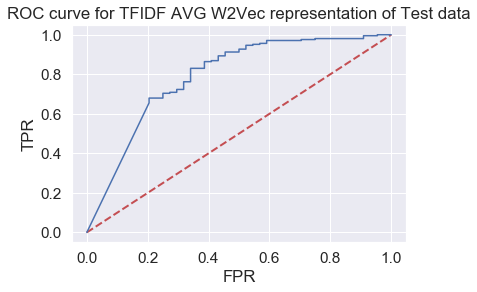

In [181]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_trim, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for TFIDF AVG W2Vec representation of Test data')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [173]:
%time
# Apply Logistic Regression on Standardized data for L1 Regularization
tfidf_sent_vectors_train_trim = tfidf_sent_vectors_train_std[:1000]
tfidf_sent_vectors_test_trim = tfidf_sent_vectors_test_std[:250]
y_train_trim = y_train[:1000]
y_test_trim = y_test[:250]
cross_val_number = 10
regularization_param = ['l2']
auc_scores_train,auc_scores_test = apply_logistic_regression_kfold(tfidf_sent_vectors_train_trim, y_train_trim, C_values, cross_val_number, regularization_param)

Wall time: 0 ns


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  8.76s/it]


In [174]:
# keeping the object in file for further use
tfidf_avgw2v_model_l2_train = 'tfidf_avgw2v_model_l2_train.pkl'
obj1 = open(tfidf_avgw2v_model_l2_train,'wb')
pickle.dump(auc_scores_train, obj1)
obj1.close()
tfidf_avgw2v_model_l2_test = 'tfidf_avgw2v_model_l2_test.pkl'
obj1 = open(tfidf_avgw2v_model_l2_test,'wb')
pickle.dump(auc_scores_test, obj1)
obj1.close()

In [175]:
# Getting the object return
tfidf_avgw2v_model_l2_train = 'tfidf_avgw2v_model_l2_train.pkl'
tfidf_avgw2v_model_l2_test = 'tfidf_avgw2v_model_l2_test.pkl'
obj9 = open(tfidf_avgw2v_model_l2_train,'rb')
auc_scores_train_tftdf_avgw2v_l2 = pickle.load(obj9)
obj9.close()
obj9 = open(tfidf_avgw2v_model_l2_test,'rb')
auc_scores_test_tftdf_avgw2v_l2 = pickle.load(obj9)
obj9.close()

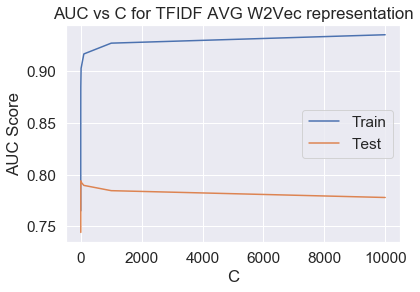

In [176]:
#plot AUC score vs C plot
plot_auc_C_curve(C_values, auc_scores_train_tftdf_avgw2v_l2, C_values, auc_scores_test_tftdf_avgw2v_l2,
                    'AUC vs C for TFIDF AVG W2Vec representation', 'C', 'AUC Score')

In [177]:
print("Best HyperParameter: ",C_values[auc_scores_test_tftdf_avgw2v_l2.index(max(auc_scores_test_tftdf_avgw2v_l2))])
print("Best Score: %.2f%%"%(max(auc_scores_test_tftdf_avgw2v_l2)))

Best HyperParameter:  1
Best Score: 0.79%


Accuracy on test set: 84.800%
Precision on test set: 0.893
Recall on test set: 0.927
F1-Score on test set: 0.910



Confusion Matrix of test set


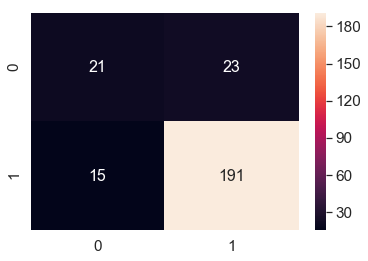

In [178]:
# Apply Naive bayes on Test data
lr_optimal = LogisticRegression(penalty='l1',C=1000)
lr_optimal.fit(tfidf_sent_vectors_train_trim, y_train_trim)
log_proba = lr_optimal.predict_log_proba(tfidf_sent_vectors_test_trim)
pred = lr_optimal.predict(tfidf_sent_vectors_test_trim)
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test_trim, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test_trim, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test_trim, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test_trim, pred)))
print("\n\n")
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test_trim, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

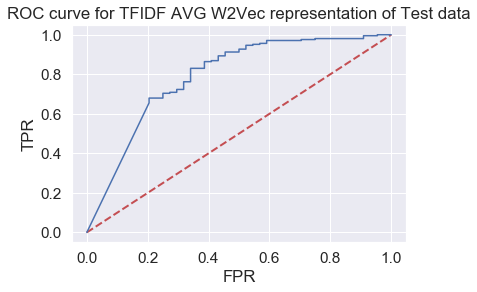

In [182]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_trim, log_proba[:, 1])
plot_roc_curve_for_test(fpr, tpr, 'ROC curve for TFIDF AVG W2Vec representation of Test data')

# [6] Conclusions

In [186]:
from prettytable import PrettyTable

In [187]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Regularization", "Hyper Parameter", "Accuracy", "Precision", "Recall", "F1 Score"]

x.add_row(["BoW", "L1", 1, "91.740%", 0.933, 0.971, 0.951])
x.add_row(["BoW", "L2", 1, "91.490%", 0.927, 0.975, 0.950])
x.add_row(["TFIDF", "L1", 1, "93.255%", 0.946, 0.975, 0.960])
x.add_row(["TFIDF", "L2", 1, "93.512%", 0.945, 0.979, 0.962])
x.add_row(["Avg-W2Vec", "L1", 10000, "82.000%", 0.882, 0.903, 0.892])
x.add_row(["Avg-W2Vec", "L2", 1, "85.200%", 0.889, 0.937, 0.913])
x.add_row(["TFIDF W2Vec", "L1", 10000, "85.600%", 0.897, 0.932, 0.914])
x.add_row(["TFIDF W2Vec", "L2", 1, "84.800%", 0.893, 0.927, 0.910])

print(x)

+-------------+----------------+-----------------+----------+-----------+--------+----------+
|  Vectorizer | Regularization | Hyper Parameter | Accuracy | Precision | Recall | F1 Score |
+-------------+----------------+-----------------+----------+-----------+--------+----------+
|     BoW     |       L1       |        1        | 91.740%  |   0.933   | 0.971  |  0.951   |
|     BoW     |       L2       |        1        | 91.490%  |   0.927   | 0.975  |   0.95   |
|    TFIDF    |       L1       |        1        | 93.255%  |   0.946   | 0.975  |   0.96   |
|    TFIDF    |       L2       |        1        | 93.512%  |   0.945   | 0.979  |  0.962   |
|  Avg-W2Vec  |       L1       |      10000      | 82.000%  |   0.882   | 0.903  |  0.892   |
|  Avg-W2Vec  |       L2       |        1        | 85.200%  |   0.889   | 0.937  |  0.913   |
| TFIDF W2Vec |       L1       |      10000      | 85.600%  |   0.897   | 0.932  |  0.914   |
| TFIDF W2Vec |       L2       |        1        | 84.800%  

### Overall Observation
* Features are multi-collinear, so before modelling we need to discard redundant features
* TFIDF Featurization performs best with accuracy of 93.512